# Introduction
This code deals with the 2D plane-strain simulation of a uniaxial compressive test on a fiber-reinforced concrete specimen, where the material behaivor is described by the elasto-plastic Drucker-Prager model with a linear shear softening law defined in terms of the cohesion. The implementation is done with Firedrake, an automated system for finite element method solution, in Google Colab.

In [ ]:
## for debugging
# !pip install -Uqq ipdb
# import ipdb
# %pdb on
# %pdb off

In [ ]:
# make plots appear in the notebook
%matplotlib inline 

# import necessary Python libraries
import matplotlib.pyplot as plt
import numpy as np

# access Google Drive from Colab
from google.colab import drive
drive.mount('/content/drive')

# load Firedrake on Colab
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake
from firedrake import *

In [ ]:
# create an output directory and make it the current one 
import os
!mkdir out_files
os.chdir('out_files')

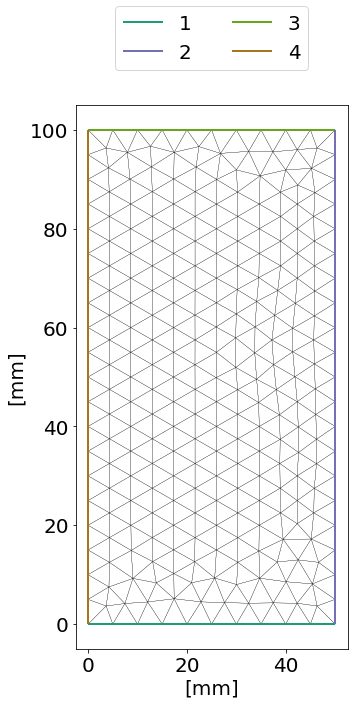

In [ ]:
# specimen geometry: width, height = 50, 100 [mm]
# load the mesh generated with Gmsh
mesh = Mesh('/content/drive/My Drive/Colab Notebooks/rectangle_coarse.msh')

# plot the mesh
fig, axes = plt.subplots(figsize=(5, 10))
triplot(mesh, axes=axes, interior_kw={'linewidth': 0.2}, boundary_kw={'linewidth': 2})
axes.set(xlabel='[mm]', ylabel='[mm]')
axes.set_aspect("equal")
# axes.axis('off')
axes.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2);
plt.rcParams.update({'font.size': 20})

# Implementation
2D quadratic elements are used. A standard "CG" space is defined for the displacement (2-dimensional vector) whereas the stress (4-dimensional vector) and the cumulative plastic strain (scalar) are represented using "Quadrature" elements. The components in the stress vector are placed in the order: [$\sigma_{xx}$, $\sigma_{yy}$, $\tau_{xy}$, $\sigma_{zz}$].

In [ ]:
## define FE function spaces ##
# CG: standard scalar Lagrange finite elements (continuous piecewise polynomial functions)
# Quadrature: artificial "finite elements" with degrees of freedom being function evaluations at quadrature points
# DG: scalar discontinuous Lagrange finite elements (discontinuous piecewise polynomial functions)

deg_u = 2 # degree of the CG element
deg_stress = 2 # degree of the Quadrature element

V = VectorFunctionSpace(mesh, "CG", deg_u) # for displacement vector (u)

We = VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=4, quad_scheme='default') 
W = FunctionSpace(mesh, We) # for stress vector (sig) and flow orientation vector (N)
W0e = FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
W0 = FunctionSpace(mesh, W0e) # for internal scalars (A, B, eps_p, check)

P0 = FunctionSpace(mesh, "DG", 0) # for output of equivalent plastic strain (ep_avg)
S0 = VectorFunctionSpace(mesh, "DG", 1, dim=3) # for output of in-plane stress vector (sig_vector)

# a custom integration measure to match the quadrature degree and scheme used by the Quadrature elements   
metadata = {"quadrature_degree": deg_stress, "quadrature_scheme": "default"}
dxm = dx(metadata=metadata)

In [ ]:
# define functions to keep track of the state in the currently computed increment
u = Function(V, name="Displacement")
du = Function(V, name="Global iteration correction")
Du = Function(V, name="Current displacement increment")
u_ = TrialFunction(V)
v = TestFunction(V)

sig = Function(W, name="Stress")
sig_old = Function(W) # converged stress from the previous global increment
N = Function(W) # flow orientation vector

A = Function(W0) # a scalar for defining the consistent tangent operator 
B = Function(W0) # a scalar for defining the consistent tangent operator 
eps_p = Function(W0, name="Cumulative plastic strain")
check = Function(W0) # a scalar for selecting between return to the smooth surface and return to the apex

ep_avg = Function(P0, name="Equivalent plastic strain") 
sig_vector = Function(S0, name="In-plane stresses")

In [ ]:
## define model parameters ##

# elastic parameters
E = Constant(30e3) # Young's modulus [MPa]
nu = Constant(0.2) # Poisson's ratio

# Lame parameters
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

G=mu # shear modulus
K=E/(3*(1-2*nu)) # bulk modulus

# constitutive parameters (with reference to Mohr-Coulomb model)
phi = Constant(np.deg2rad(35)) # frictional angle [degree]
psi = Constant(np.deg2rad(5)) # dilatancy angle [degree]
c0 = Constant(3) # initial cohesion [MPa]

xi = 3/sqrt(9+12*tan(phi)**2) # a constant for defining the yield function
eta = xi*tan(phi) # a constant for defining the yield function
eta_bar = 3*tan(psi)/sqrt(9+12*tan(psi)**2) # a constant for defining the plastic potential function

H = -G/100 # softening slope
c = c0+H*eps_p # linear softening law

# other useful constants in the return-mapping procedure
C = G+K*eta*eta_bar+H*xi**2
alpha = xi/eta
beta = xi/eta_bar

In [ ]:
## define useful functions for performing the return mapping procedure and the solution update ##

I = Identity(3) # 3D identity tensor

# total strain tensor (3D)
def epsilon(u_):
    e = sym(grad(u_)) # = 0.5*(grad(u_)+grad(u_).T)
    return as_tensor([[e[0, 0], e[0, 1], 0],
             [e[0, 1], e[1, 1], 0],
             [0, 0, 0]])

# elastic consitutive relation
def sigma(eps_el):
    return lmbda*tr(eps_el)*I+2*mu*eps_el

# represent a 4-dimensional vector as a 3D tensor
def as_3D_tensor(X):
    return as_tensor([[X[0], X[3], 0],
             [X[3], X[1], 0],
             [0, 0, X[2]]])

# a 3-dimensional vector containing only the in-plane components  
def as_3_vector(X):
    return as_vector([X[0], X[1], X[3]]) 
    
# local projection back onto the Quadrature spaces
def local_project(u_, V):
    return project(u_, V, form_compiler_parameters={"quadrature_degree":deg_stress})  

In [ ]:
## return mapping procedure for local constitutive update ##

# functions used to account for both elastic and plastic evolution
pos = lambda x: (x+abs(x))/2 # take the positive part of x, i.e., return x if x>0 and return 0 if x<=0
flag = lambda x: conditional(x>0, 1, 0) # return 1 if x>0 and return 0 if x<=0

def return_map(deps, old_sig):
    # elastic predictor step
    sig_n = as_3D_tensor(old_sig) # converged stress tensor from the previous load increment
    sig_trial = sig_n+sigma(deps) # trial stress tensor 
    s = dev(sig_trial) # deviatoric stress of the trial stress tensor 
    J2 = inner(s, s)/2 # J2 invariant of the trial stress tensor 
    p = tr(sig_trial)/3 # hydrostatic pressure of the trial stress tensor 
    f_trial = sqrt(J2)+eta*p-xi*c # evaluate the yield function with the trial stress state
    # plastic corrector step
    # first assume return to the smooth surface:
    N = s/sqrt(2*J2)*flag(f_trial) # flow orientation tensor; flag(f_trial) is used to distinguish between elastic (f_trial<=0 --> N=0) and plastic (f_trial>0) evolution
    dgam = pos(f_trial)/C # plastic multiplier; pos(f_trial) is used to distinguish between elastic (f_trial<=0 --> dgam=0) and plastic (f_trial>0) evolution
    A = flag(f_trial)/C
    B = G*dgam/sqrt(J2) 
    check = sqrt(J2)-G*dgam # check if return to smooth surface is valid (check>=0) or not (check<0)
    # if return to the apex:
    r = c*beta-p
    depv = -r/(alpha*beta*H+K) # volumetric plastic strain
    # return to smooth surface if check>=0, return to apex if not
    dep = conditional(ge(check, 0), xi*dgam, alpha*depv) # equivalent plastic strain increment
    sig_new = conditional(ge(check, 0), sig_trial-dgam*(G*s/sqrt(J2)+K*eta_bar/3*I), (p-K*depv)*I) # stress update 
    return as_vector([sig_new[0, 0], sig_new[1, 1], sig_new[2, 2], sig_new[0, 1]]), \
               as_vector([N[0, 0], N[1, 1], N[2, 2], N[0, 1]]), \
               dep, A, B, check

In order to apply the Newton-Raphson method to resolve global equilibrium with optimal convergence rate, the algorithmic consistent tangent operator $\mathbf{D}_t$ is needed. Instead of storing $\mathbf{D}_t$ as a 4th-order tensor, the consistent tangent stress is computed as $\boldsymbol{\sigma}_t=\mathbf{D}_t \boldsymbol{\epsilon}$ and is used in the linearized global variational form.

In [ ]:
## compute consistent tangent stress ##

# if return to the smooth surface:
def sigt_smooth(e):
    N_n = as_3D_tensor(N)
    return  2*G*(1-B)*dev(e)+2*G*(B-G*A)*inner(N_n, e)*N_n-sqrt(2)*G*K*A*(eta*inner(I, e)*N_n+eta_bar*inner(N_n, e)*I)+K*(1-K*eta*eta_bar*A)*inner(I, e)*I

# if return to the apex:
def sigt_apex(e):
    return  K*alpha*beta*H/(K+alpha*beta*H)*inner(I, e)*I

# select between return to smooth surface (check>=0) and return to apex (check<0)
def sig_tg(e):
    return  conditional(ge(check, 0), sigt_smooth(e), sigt_apex(e))

In [ ]:
## Newton-Raphson procedure for solving global equilibrium problem ##
''' Each iteration will establish equilibrium by driving to zero the residual between 
the internal forces associated with the current stress state and the external forces. '''

# boundary conditions: displacement control on the bottom (marked 1) & top (marked 3) boundaries
m = Constant(0) # load multiplier for incremental loading
u_bc = 0.05 # imposed total displacement magnitude at both top and bottom [mm]
bcs = [DirichletBC(V.sub(1), (m*u_bc-u[1]-Du[1]), 1), DirichletBC(V.sub(1), (-m*u_bc-u[1]-Du[1]), 3)] # uniaxial compressive loading
bc0 = [DirichletBC(V.sub(1), 0, 1), DirichletBC(V.sub(1), 0, 3)] # homogeneous version of the boundary conditions, i.e., with imposed displacements equal to zero

# linearized variational form to solve for du over each iteration
Kt = inner(epsilon(v), sig_tg(epsilon(u_)))*dxm # lhs tangent stiffness matrix
res = -inner(epsilon(v), as_3D_tensor(sig))*dxm # rhs residual (out-of-balance force) vector

# create rigid body modes
x, y = SpatialCoordinate(mesh)
b0 = Function(V)
b1 = Function(V)
b2 = Function(V)
b0.interpolate(Constant([1, 0])) # rigid-body horizontal translation
b1.interpolate(Constant([0, 1])) # rigid-body vertical translation
b2.interpolate(as_vector([-y, x])) # rigid-body in-plane rotation
nullmodes = VectorSpaceBasis([b0, b1, b2])
nullmodes.orthonormalize()

# define the linear problem and set the solver
lin_problem = LinearVariationalProblem(Kt, res, du, bcs)
solver_parameters = {"ksp_type": "gmres", "pc_type": "lu"}
lin_solver = LinearVariationalSolver(lin_problem, solver_parameters=solver_parameters, nullspace=nullmodes)

# create output file
outfile = File("ucs_dp_frc.pvd")
outfile.write(u, ep_avg, sig_vector, time=0)
freq = 2 # output frequency (every n increments)

# set up global Newton-Raphson loop
Nitermax, tol = 100, 1e-5 # maximum number of iterations and absolute tolerance for each load increment
Nincr = 100 # number of loading increments
steps = np.linspace(0, 1, Nincr+1)**0.5 # pseudo-time (load) steps

RF = [0] # vertical reaction force at top [N/mm]
sigy = [0] # vertical stress at top midpoint [MPa]
disp = [0] # vertical displacement at top midpoint [mm]

for (i, t) in enumerate(steps[1:]):
    print("Increment:", str(i+1))
    m.assign(t) # increase the load multiplier step by step
    Du.interpolate(Constant([0, 0])) # initialize the displacement increment
    nRes = 1 # initialize the residual norm
    niter = 0 # initiate the iteration loop
    while nRes > tol and niter < Nitermax:
        lin_solver.solve() # solve the linearized equation for du
        Du.assign(Du+du) # update Du
        deps = epsilon(Du) # current total strain increment
        # ipdb.set_trace(context=6) # add a breakpoint
        # perform return-mapping procedure for constitutive update
        sig_, N_, dep_, A_, B_, check_ = return_map(deps, sig_old)
        sig.assign(local_project(sig_, W))
        N.assign(local_project(N_, W))
        A.assign(local_project(A_, W0))
        B.assign(local_project(B_, W0))
        check.assign(local_project(check_, W0))
        # update and print the residual norm
        nRes = norm(assemble(res, bcs=bc0))
        print(" Residual:", nRes)
        niter += 1 # track the iteration number
    # after convergence of the current iteration loop, update displacement, stress, and cumulative plastic strain
    u.assign(u+Du)
    sig_old.assign(sig)
    eps_p.assign(eps_p+local_project(dep_, W0))
    # projections for output of in-plane stress state and equivalent plastic strain
    sig_vector.assign(local_project(as_3_vector(sig), S0))
    ep_avg.assign(project(eps_p, P0))
    # record the evolution of resulting quantities of interest
    RF.append(assemble(sig_vector[1]*ds(3)))
    sigy.append(sig_vector([25,99.99])[1])
    disp.append(u([25,99.99])[1])
    # write output file
    if i % freq == 0:
        outfile.write(u, ep_avg, sig_vector, time=t)
    # terminate the loading loop if solution nonconvergence occurs
    if nRes>1:
            break

Increment: 1
 Residual: 5.446714603097786e-12
Increment: 2
 Residual: 3.727820768546355e-12
Increment: 3
 Residual: 9.068365479456532e-13
Increment: 4
 Residual: 5.124498919751485e-13
Increment: 5
 Residual: 4.2475398789409644e-13
Increment: 6
 Residual: 1.163138389423279
 Residual: 0.08078019213136374
 Residual: 0.0062372523972425
 Residual: 0.0004781648834902615
 Residual: 3.667770646337284e-05
 Residual: 2.8132495375712683e-06
Increment: 7
 Residual: 0.52671618147722
 Residual: 0.04491107081597874
 Residual: 0.0036686979585046284
 Residual: 0.0003007984160158352
 Residual: 2.4655178151623093e-05
 Residual: 2.0209309999070832e-06
Increment: 8
 Residual: 0.42172490052456246
 Residual: 0.03690748170910873
 Residual: 0.0031221694975894112
 Residual: 0.0002649109534494385
 Residual: 2.2471566583176404e-05
 Residual: 1.9062335910977606e-06
Increment: 9
 Residual: 0.39574983698551963
 Residual: 0.03558855006865531
 Residual: 0.0031008474293192753
 Residual: 0.00027095303454196005
 Residual

# Post-processing

In [ ]:
# save the history output into a CSV file
output = np.asarray([steps[:len(RF)], RF, sigy, disp]).T
np.savetxt('output_ucs_dp_frc.csv', output, delimiter=',', header='step, RF [N/mm], sigy [MPa], disp [mm]')
## or alternatively:
# import csv 
# with open("output_data.csv", "w") as f:     
#     writer = csv.writer(f)     
#     writer.writerows(output)

# copy the output files into Google Drive
%cp -av "/content/out_files" "/content/drive/MyDrive/Colab Notebooks/Thesis/output data/UCS_DP_FRC"

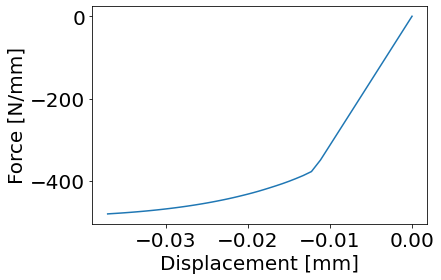

In [ ]:
plt.plot(disp, RF, "-")
plt.xlabel("Displacement [mm]")
plt.ylabel("Force [N/mm]")
plt.show()

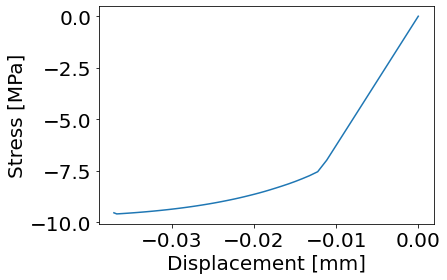

In [ ]:
plt.plot(disp, sigy, "-")
plt.xlabel("Displacement [mm]")
plt.ylabel("Stress [MPa]")
plt.show()

In [ ]:
# take the magnitude of negative quantities
RF_mag = np.zeros((len(RF),1))
disp_mag = np.zeros((len(disp),1))
sigy_mag = np.zeros((len(sigy),1))
for i in range(len(RF)):
    RF_mag[i] = abs(RF[i])
    disp_mag[i] = abs(disp[i])
    sigy_mag[i] = abs(sigy[i])

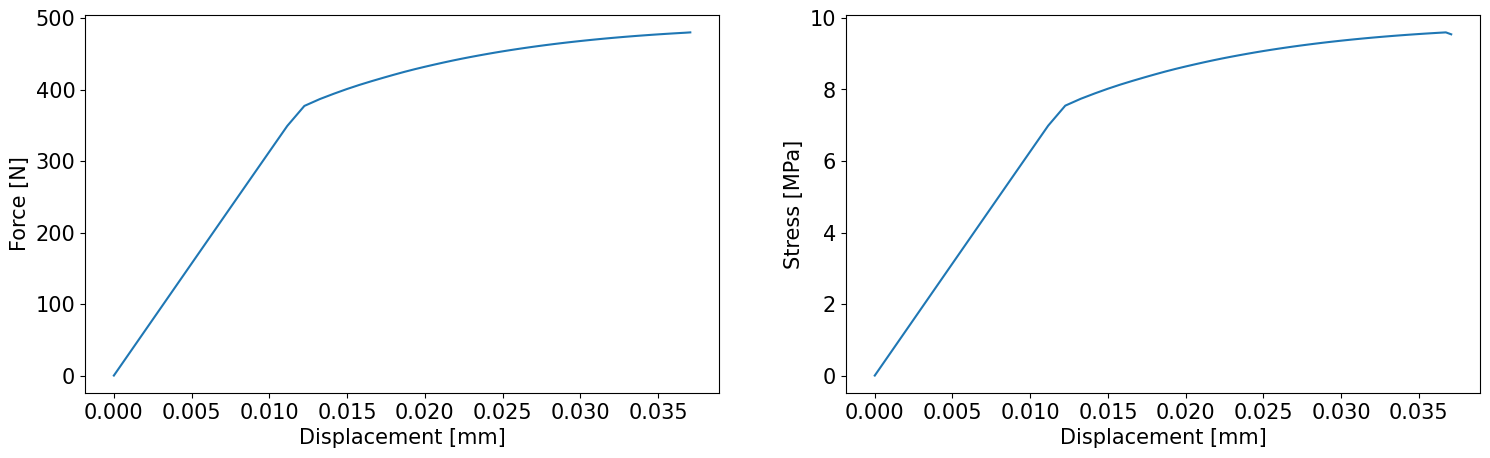

In [ ]:
# plot force-displacement and stress-displacement curves recorded at the top of the specimen
from matplotlib.ticker import FormatStrFormatter
fig, axes = plt.subplots(1, 2, figsize=(18, 5), dpi=100)
plt.rcParams.update({'font.size': 15})
axes[0].plot(disp_mag, RF_mag, "-")
axes[0].set(xlabel='Displacement [mm]', ylabel='Force [N]');
axes[0].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
axes[1].plot(disp_mag, sigy_mag, "-")
axes[1].set(xlabel='Displacement [mm]', ylabel='Stress [MPa]');
axes[1].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

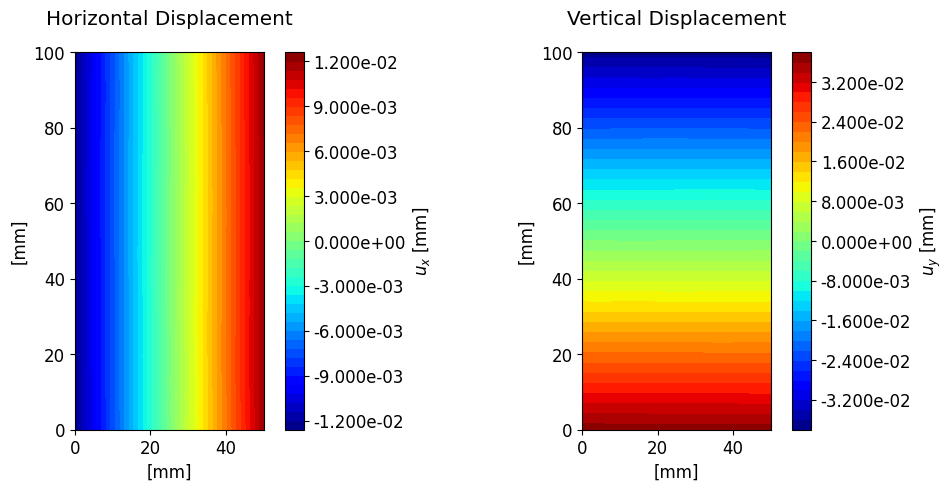

In [ ]:
# plot displacement fields
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
plt.rcParams.update({'font.size': 12})
tc = tricontourf(u.sub(0), levels=40, axes=axes[0], cmap='jet')
cb = plt.colorbar(tc, ax=axes[0], label='$u_x$ [mm]', format='%.3e')
axes[0].set_title('Horizontal Displacement', pad=20)
axes[0].set_aspect("equal")
axes[0].set(xlabel='[mm]', ylabel='[mm]');
tc = tricontourf(u.sub(1), levels=40, axes=axes[1], cmap='jet')
cb = plt.colorbar(tc, ax=axes[1], label='$u_y$ [mm]', format='%.3e')
axes[1].set_title('Vertical Displacement', pad=20)
axes[1].set_aspect("equal")
axes[1].set(xlabel='[mm]', ylabel='[mm]');

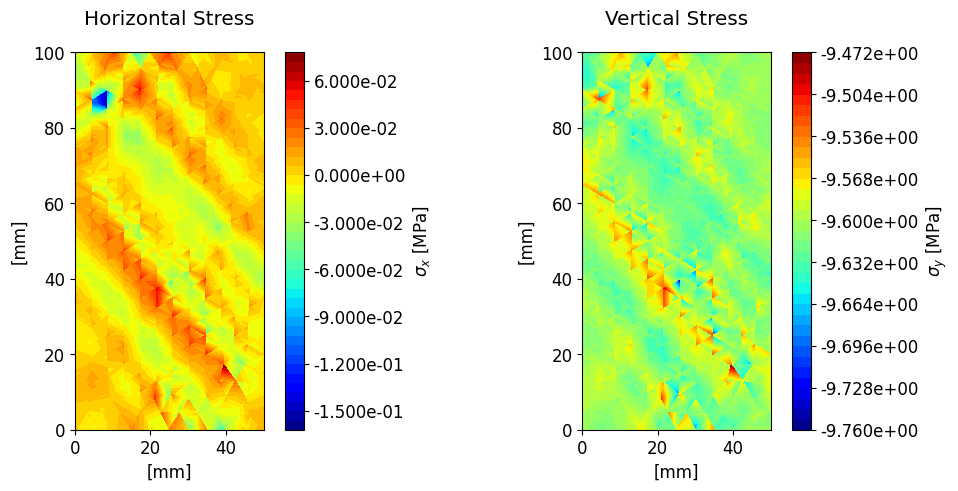

In [ ]:
# plot stress fields
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
plt.rcParams.update({'font.size': 12})
tc = tricontourf(sig_vector.sub(0), levels=40, axes=axes[0], cmap='jet')
cb = plt.colorbar(tc, ax=axes[0], label='$\sigma_x$ [MPa]', format='%.3e')
axes[0].set_title('Horizontal Stress', pad=20)
axes[0].set_aspect("equal")
axes[0].set(xlabel='[mm]', ylabel='[mm]');
tc = tricontourf(sig_vector.sub(1), levels=40, axes=axes[1], cmap='jet')
cb = plt.colorbar(tc, ax=axes[1], label='$\sigma_y$ [MPa]', format='%.3e')
axes[1].set_title('Vertical Stress', pad=20)
axes[1].set_aspect("equal")
axes[1].set(xlabel='[mm]', ylabel='[mm]');

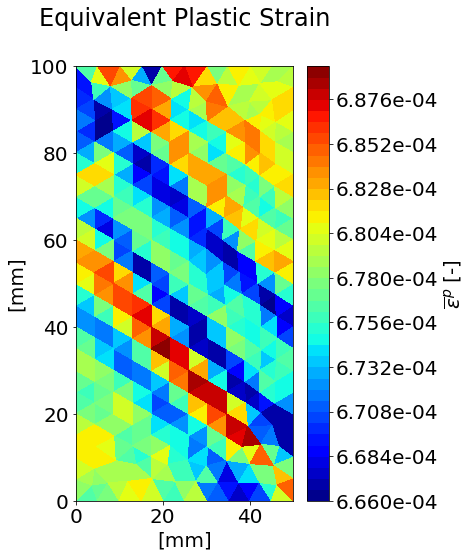

In [ ]:
# plot the field of equivalent plastic strain
fig, axes = plt.subplots(figsize=(5, 8))
plt.rcParams.update({'font.size': 20})
tc = tricontourf(ep_avg, levels=40, axes=axes, cmap='jet')
cb = plt.colorbar(tc, ax=axes, label='$\overline{\epsilon}^p$ [-]', format='%.3e')
axes.set_title('Equivalent Plastic Strain', pad=40)
axes.set_aspect("equal")
axes.set(xlabel='[mm]', ylabel='[mm]');